In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from pathlib import Path

In [ ]:
"""  

This Code block takes the output plots of function fitting and combines them with a given root

"""

def combine_ff_plots(ROOT):
    func_dirs = [p for p in ROOT.iterdir() if p.is_dir()]
    functions = sorted([p.name for p in func_dirs])

    all_models = set()
    per_func_models = {}
    for f in functions:
        mdirs = [p for p in (ROOT / f).iterdir() if p.is_dir()]
        models = sorted([p.name for p in mdirs])
        per_func_models[f] = models
        all_models.update(models)
    models_union = sorted(all_models)

    n_rows = len(functions)
    n_cols = 1 + len(models_union)  # GT + each model
    fig_w = max(6, 3 * n_cols)
    fig_h = max(3, 3 * n_rows)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False)
    plt.subplots_adjust(left=0.14, wspace=0.05, hspace=0.15)

    for r, func in enumerate(functions):
        gt_img = None
        for m in per_func_models[func]:
            candidate = ROOT / func / m / f"{func}_gt.png"
            if candidate.exists():
                gt_img = imread(candidate)
                break

        # column 0 = GT
        ax = axes[r, 0]
        ax.axis("off")
        if gt_img is not None:
            ax.imshow(gt_img)
            ax.set_title("GT" if r == 0 else "")
        # ax.set_ylabel(func, rotation=90, labelpad=12, fontsize=11, va="center")
        axes[r, 0].text(
            -0.02, 0.5, func,
            transform=axes[r, 0].transAxes,
            ha="right", va="center",
            fontsize=11, fontweight="bold",
            clip_on=False
        )

        for c, model in enumerate(models_union, start=1):
            ax = axes[r, c]
            ax.axis("off")
            pred_path = ROOT / func / model / f"{func}_pred.png"
            if pred_path.exists():
                ax.imshow(imread(pred_path))
            else:
                ax.text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=10, color="0.5")
            if r == 0:
                ax.set_title(model, fontsize=10)

    plt.tight_layout()
    plt.show()

    records = []
    for func in functions:
        for model in per_func_models[func]:
            tj = ROOT / func / model / "training.json"
            if not tj.exists():
                continue
            try:
                dfj = pd.read_json(tj, lines=True)
            except ValueError:
                dfj = pd.read_json(tj)

            final_loss = pd.to_numeric(dfj.get("final_loss"), errors="coerce").dropna()
            if not final_loss.empty:
                loss_val = float(final_loss.iloc[-1])
            else:
                loss_series = pd.to_numeric(dfj.get("loss"), errors="coerce").dropna()
                loss_val = float(loss_series.iloc[-1]) if not loss_series.empty else np.nan

            records.append({"model": model, "function": func, "final_loss": loss_val})

    loss_df = pd.DataFrame(records)
    loss_pivot = (loss_df
                .pivot_table(index="model", columns="function", values="final_loss", aggfunc="first")
                .sort_index())

    print("\nFinal loss (rows=models, cols=functions)")
    print(loss_pivot.round(4).to_string())


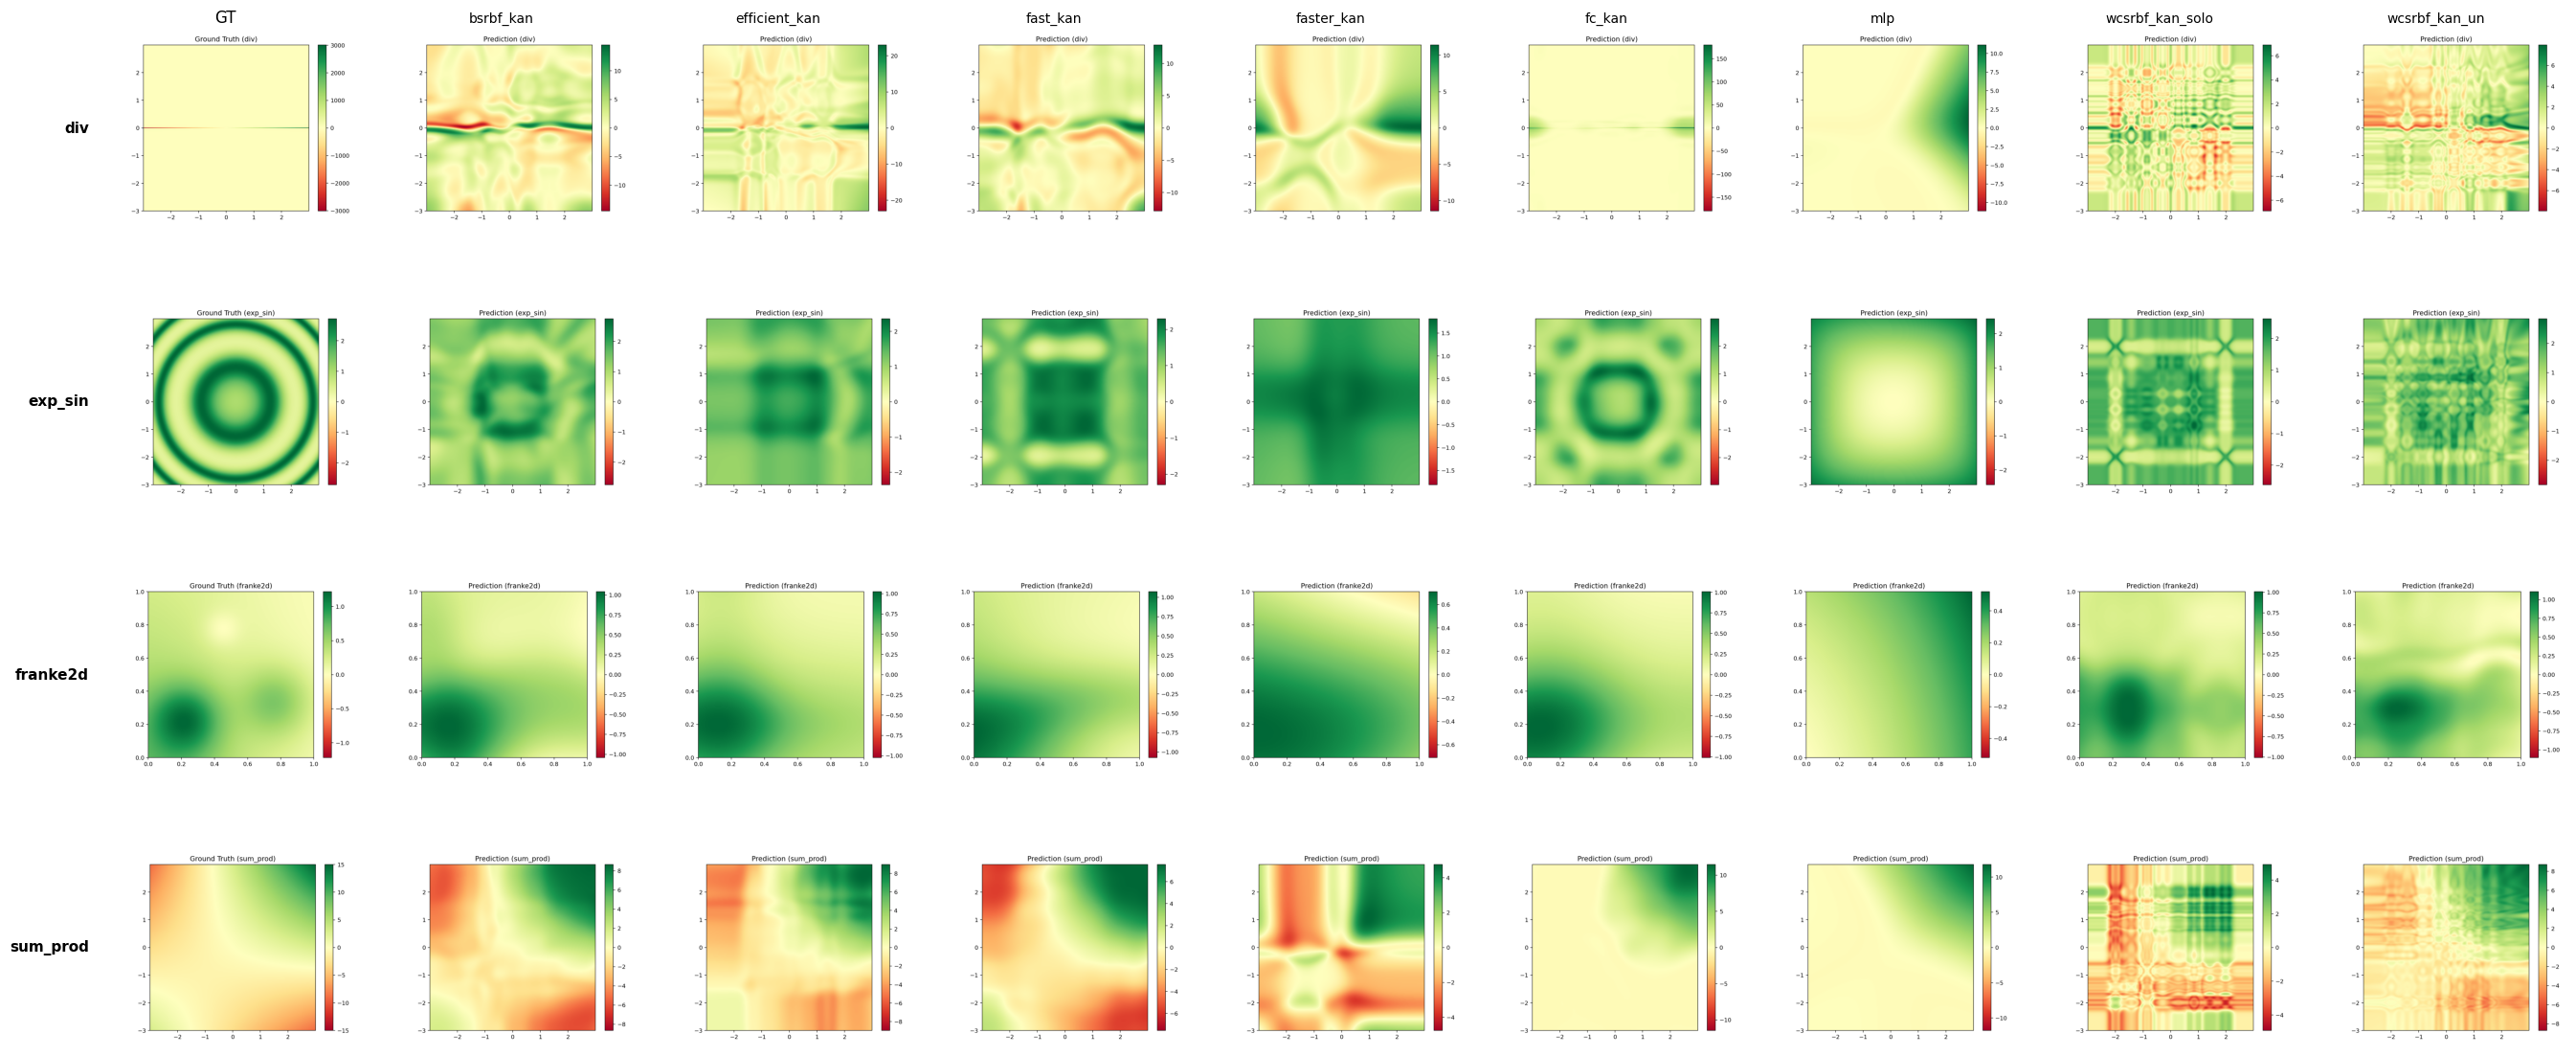


Final loss (rows=models, cols=functions)
function               div  exp_sin  franke2d  sum_prod
model                                                  
bsrbf_kan        7715.7515   0.3968    0.0083    0.4358
efficient_kan    7705.6333   0.5354    0.0168    1.0360
fast_kan         7728.4526   0.4454    0.0112    0.6510
faster_kan       7746.3237   0.6448    0.0321    7.7127
fc_kan           7367.1079   0.3237    0.0126    4.9875
mlp              7758.6367   1.3214    0.1764    5.3032
wcsrbf_kan_solo  7746.6055   0.4063    0.0184   10.8955
wcsrbf_kan_un    7741.1597   0.5189    0.0195    2.7861


In [8]:
ROOT = Path("./output_ff1")
combine_ff_plots(ROOT=ROOT)

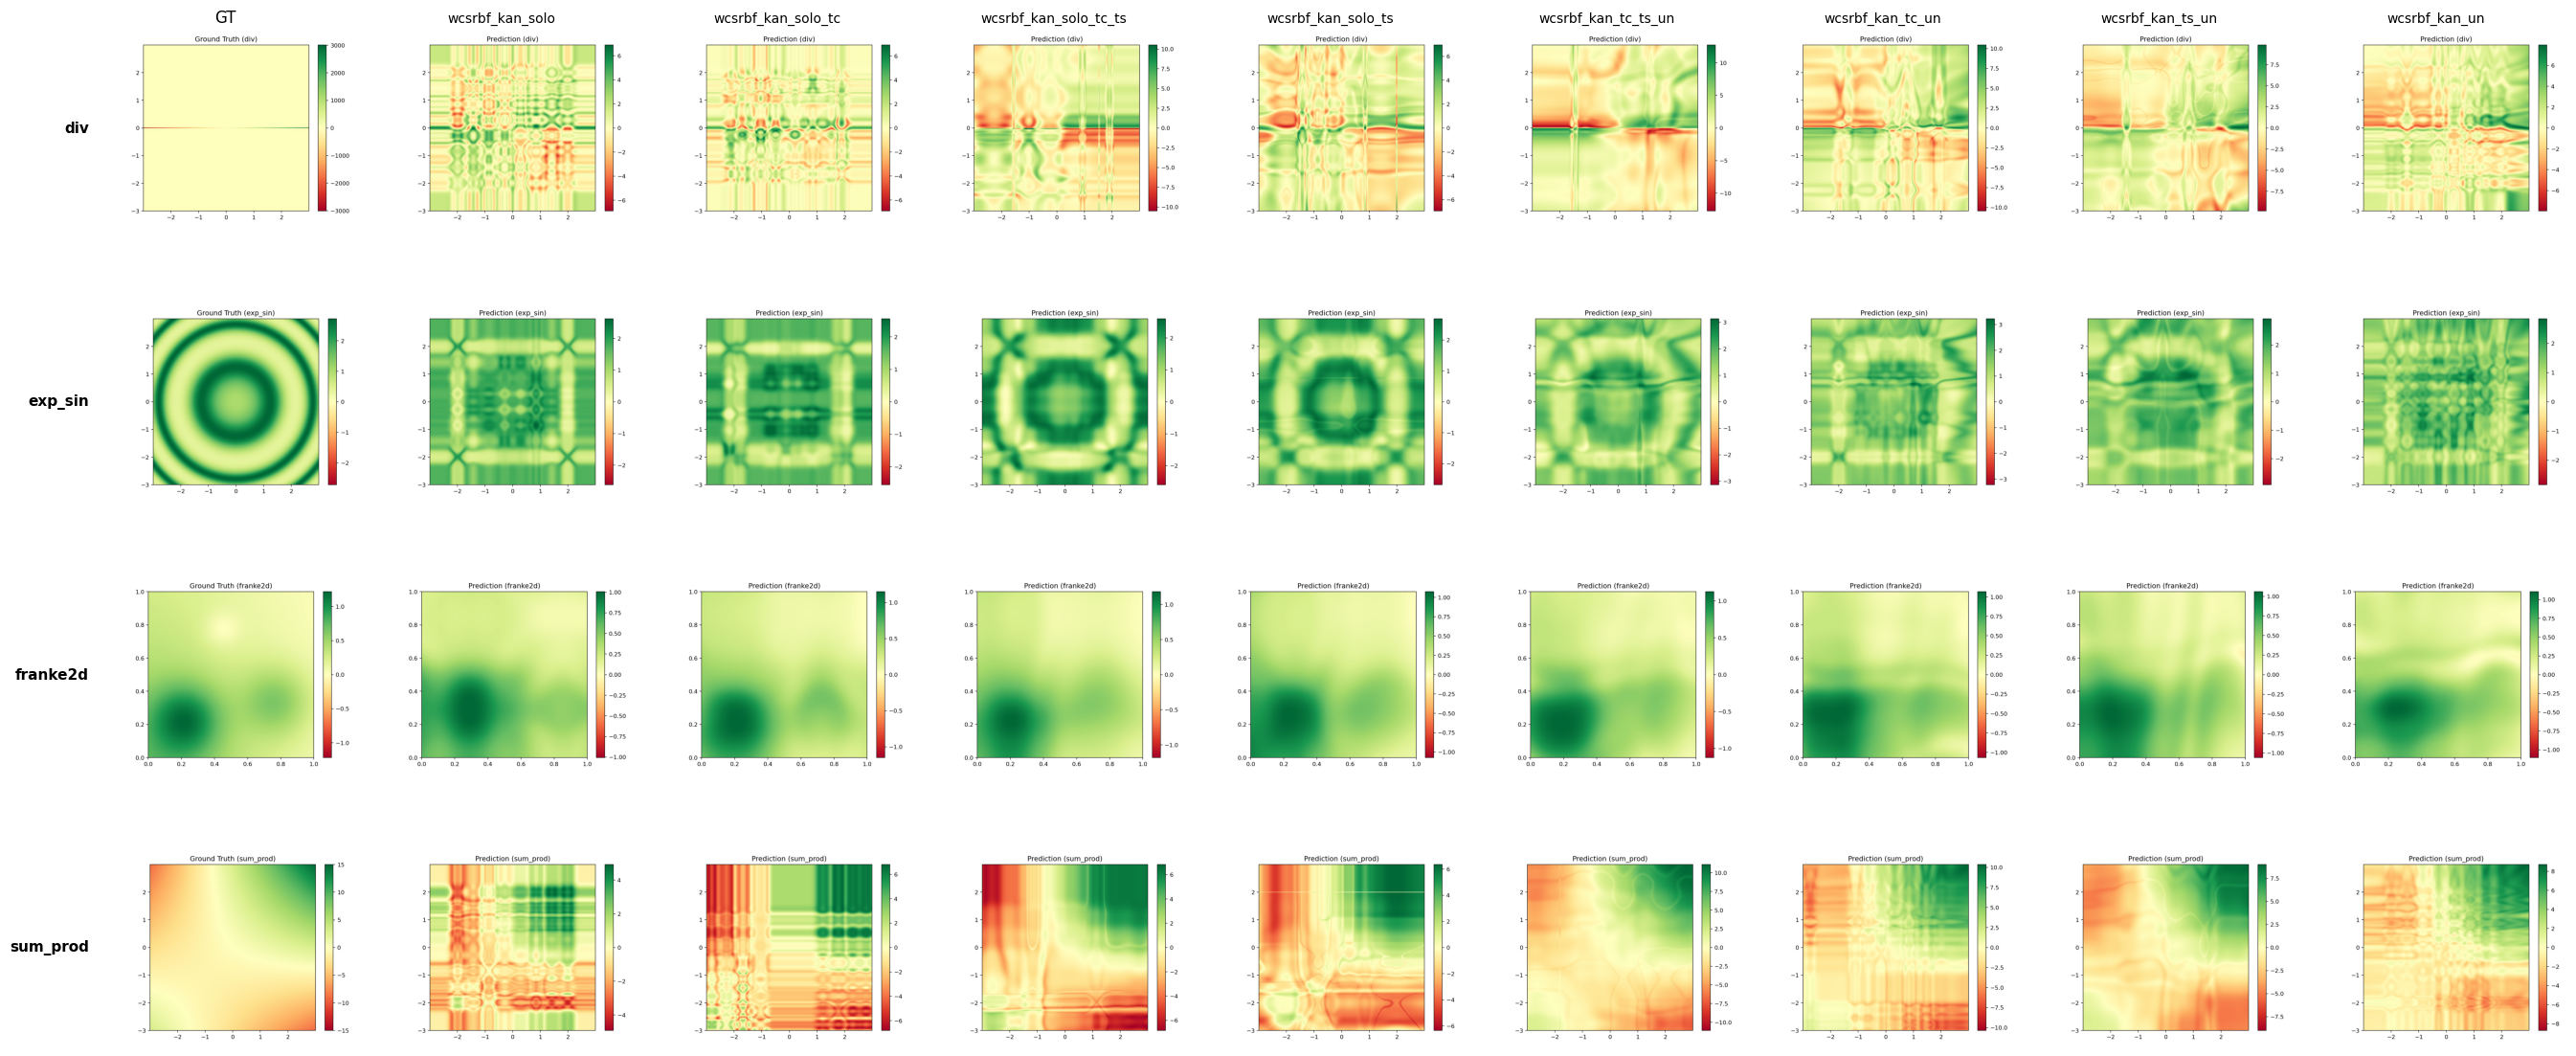


Final loss (rows=models, cols=functions)
function                     div  exp_sin  franke2d  sum_prod
model                                                        
wcsrbf_kan_solo        7746.6055   0.4063    0.0184   10.8955
wcsrbf_kan_solo_tc     7748.3496   0.3592    0.0039    2.4154
wcsrbf_kan_solo_tc_ts  7726.0703   0.2454    0.0359    1.2438
wcsrbf_kan_solo_ts     7742.4810   0.2791    0.0378    2.5284
wcsrbf_kan_tc_ts_un    7692.7842   0.3209    0.0406    0.3104
wcsrbf_kan_tc_un       7718.3989   0.3530    0.0081    0.8753
wcsrbf_kan_ts_un       7727.4092   0.4326    0.0430    0.8149
wcsrbf_kan_un          7741.1597   0.5189    0.0195    2.7861


In [9]:
ROOT = Path("./output_ff_wcsrbf") 
combine_ff_plots(ROOT=ROOT)
